In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from glob import glob
import torch
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerFeatureExtractor
from transformers import SegformerForSemanticSegmentation
from huggingface_hub import cached_download, hf_hub_url
from datasets import load_metric

import albumentations as A
from albumentations.pytorch import ToTensorV2

seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device.upper()}" device.')

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

batch_size = 1
num_classes = 19
epochs = 20
path = r'segform_model.pth'

Currently using "CUDA" device.


In [2]:
image_paths = []
masks_paths = []
color_paths = []
folders = os.listdir('/kaggle/input/cityscapes/Cityspaces/images/train')
print(folders)

['dusseldorf', 'darmstadt', 'tubingen', 'erfurt', 'bochum', 'krefeld', 'weimar', 'bremen', 'aachen', 'hamburg', 'monchengladbach', 'hanover', 'zurich', 'jena', 'stuttgart', 'strasbourg', 'cologne', 'ulm']


In [3]:
IMG_PATH = '/kaggle/input/cityscapes/Cityspaces/images/train'
MASK_PATH= '/kaggle/input/cityscapes/Cityspaces/gtFine/train'
COLOR_PATH = MASK_PATH

In [4]:
for folder in folders:
    if folder != '.DS_Store':
        img_paths = sorted(glob(os.path.join(IMG_PATH, folder, '*.png')))
        mask_paths = sorted(glob(os.path.join(MASK_PATH, folder, '*_labelIds.png')))
        _color_paths = sorted(glob(os.path.join(COLOR_PATH, folder, '*_color.png')))
        print(folder, len(img_paths), len(mask_paths), len(_color_paths))
        image_paths.extend(img_paths)
        masks_paths.extend(mask_paths)
        color_paths.extend(_color_paths)

dusseldorf 221 221 221
darmstadt 85 85 85
tubingen 144 144 144
erfurt 109 109 109
bochum 96 96 96
krefeld 99 99 99
weimar 142 142 142
bremen 316 316 316
aachen 174 174 174
hamburg 248 248 248
monchengladbach 94 94 94
hanover 196 196 196
zurich 122 122 122
jena 119 119 119
stuttgart 196 196 196
strasbourg 365 365 365
cologne 154 154 154
ulm 95 95 95


In [5]:
import pandas as pd

df = pd.DataFrame({
    'image': image_paths, 
    'label_ids': masks_paths,
    'color_mask': color_paths
})
df.sample(10)

,image,label_ids,color_mask
2403,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...
2865,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...
2159,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...
507,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...
2462,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...
1235,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...
685,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...
2436,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...
2787,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...
2645,/kaggle/input/cityscapes/Cityspaces/images/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...,/kaggle/input/cityscapes/Cityspaces/gtFine/tra...


In [6]:
train, test = train_test_split(df, test_size=1000, shuffle=True, random_state=42)
train, valid = train_test_split(train, test_size=1000, shuffle=True, random_state=42)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f'Train size: {len(train)}, validation size: {len(valid)} and test size: {len(test)}')

Train size: 975, validation size: 1000 and test size: 1000


In [7]:
from collections import namedtuple

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [8]:
labels_dict = {
    'name': [],
    'train_id': [],
    'R': [],
    'G': [],
    'B': []
}

for label in labels:
    if label.trainId != 255 and label.trainId != -1:
        labels_dict['name'].append(label.name)
        labels_dict['train_id'].append(label.trainId)
        labels_dict['R'].append(label.color[0])
        labels_dict['G'].append(label.color[1])
        labels_dict['B'].append(label.color[2])


labels_df = pd.DataFrame(labels_dict)
labels_df.to_csv('./labels.csv', index=False)

In [9]:
labels_df = pd.read_csv('labels.csv')
label_to_id = {v: k for k, v in enumerate(labels_df['name'].unique())}
id_to_label = {v: k for k, v in label_to_id.items()}

num_classes = 19

palette = []
for i in range(num_classes):
    color = labels_df.iloc[i, 1:].values.tolist()
    palette.append(color)

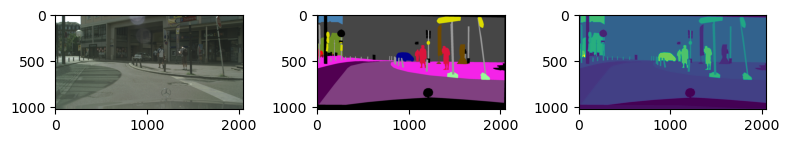

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

sample_img = df.sample(1, random_state=42)

image = Image.open(sample_img['image'].values[0])
cmask = Image.open(sample_img['color_mask'].values[0])
mask = Image.open(sample_img['label_ids'].values[0])

plt.figure(figsize=(8, 4))
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(cmask)
plt.subplot(133)
plt.imshow(mask)
plt.tight_layout()
plt.show()

In [27]:
class CityScapesDataset(Dataset):
    def __init__(self, image_paths, mask_paths, stage: str = "train", image_size: int = 1024) -> None:
        super(CityScapesDataset, self).__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size

        if stage == "train":
#             self.transforms = A.Compose([
#                 A.augmentations.Resize(height=self.image_size, width=self.image_size, interpolation=0),
#                 A.augmentations.Rotate(limit=90, p=0.5),
#                 A.augmentations.HorizontalFlip(p=0.5),
#                 A.augmentations.VerticalFlip(p=0.5),
#                 A.augmentations.transforms.ColorJitter(p=0.5),
# #                 A.Normalize(),
#                 A.pytorch.ToTensorV2(),
#             ])
            self.transforms = A.Compose([
                A.Resize(height=self.image_size, width=self.image_size, interpolation=0),
                A.Normalize( ),
#                 A.ToFloat(),
                ToTensorV2(),
            ])


        else:
            self.transforms = A.Compose([
                A.Resize(height=self.image_size, width=self.image_size, interpolation=0),
#                 A.Normalize(),
                A.ToFloat(),
                ToTensorV2()
            ])

        self.target_train_ids = []
        self.target_ids = []
        self.target_colors = []
        self.target_labels = []

        for label in labels:
            if label.trainId != 255 and label.trainId != -1:
                self.target_colors.append(label.color)
                self.target_labels.append(label.name)
                self.target_train_ids.append(label.trainId)
                self.target_ids.append(label.id)

        self.cmap = dict(zip(self.target_train_ids, self.target_colors))
        self.idmap = dict(zip(self.target_ids, self.target_train_ids))


    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image = np.array(Image.open(self.image_paths[idx]))
        mask = np.array(Image.open(self.mask_paths[idx]))

        transformed = self.transforms(image=image, mask=mask)

        image, mask = transformed['image'], transformed['mask']

        unique = pd.Series(mask.reshape(-1)).unique()

        for ele in unique:
            if ele not in self.idmap.keys():
                mask = mask.where(mask != ele, torch.tensor(255))

        unique = pd.Series(mask.reshape(-1)).unique()
        # print(unoq)
        for k, v in self.idmap.items():
            mask = mask.where(mask != k, torch.tensor(v))
            
#         mask = F.one_hot(mask, num_classes=20)

        new_mask = torch.stack([mask]*3, axis=-1)
        new_mask.shape

        for k, v in self.cmap.items():
            # print(k, v)
            new_mask = new_mask.where(new_mask != k, torch.LongTensor(v))

        return {
            'pixel_values': image.clone().to(torch.float32),
            'labels': mask.to(torch.long),
            'colored': new_mask,
            'instance': np.array(Image.open(self.mask_paths[idx]))
        }

In [32]:
train, test = train_test_split(df, test_size=1000, shuffle=True, random_state=42)
train, valid = train_test_split(train, test_size=1000, shuffle=True, random_state=42)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f'Train size: {len(train)}, validation size: {len(valid)} and test size: {len(test)}')

Train size: 975, validation size: 1000 and test size: 1000


In [33]:
image_paths = train['image']
label_paths = train['label_ids']
train_dataset = CityScapesDataset(image_paths, label_paths, image_size=1024, stage="train")

image_paths = valid['image']
label_paths = valid['label_ids']
valid_dataset = CityScapesDataset(image_paths, label_paths, image_size=1024, stage="valid")

In [34]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

In [35]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024",
                                                         num_labels=num_classes, 
                                                         id2label=id_to_label, 
                                                         label2id=label_to_id,).to(device=device)

In [36]:
metric_train = load_metric("mean_iou")
metric_valid = load_metric("mean_iou")

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
model.to(device)
print()

In [37]:
@torch.no_grad()
def evaluate_test(model=model, test=test):
    model.eval()
    idx = np.random.randint(len(test))
    image_p = test.loc[idx, 'image']
    gt_mask_p = test.loc[idx, 'mask']
    image = Image.open(image_p)
    gt_mask = Image.open(gt_mask_p)
    
    encoding = feature_extractor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(device)
    
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits.cpu()
    upsampled_logits = nn.functional.interpolate(logits,
                                                 size=image.size[::-1],
                                                 mode='bilinear',
                                                 align_corners=False)
    seg = upsampled_logits.argmax(dim=1)[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    
    np_palette = np.array(palette)
    for label, color in enumerate(np_palette):
        color_seg[seg == label, :] = color
        
    color_seg = color_seg[..., ::-1]

    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)
    
    # GT
    gt_map = np.array(gt_mask)
    gt_map[gt_map == 0] = 255
    gt_map = gt_map - 1
    gt_map[gt_map == 254] = 255

    classes_map = np.unique(gt_map).tolist()
    unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]

    color_seg = np.zeros((gt_map.shape[0], gt_map.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(np_palette):
        color_seg[gt_map == label, :] = color

    color_seg = color_seg[..., ::-1]
    
    gt_mask = np.array(image) * 0.5 + color_seg * 0.5
    gt_mask = gt_mask.astype(np.uint8)

    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Predicted Image')
    plt.imshow(img)
    
    plt.subplot(132)
    plt.title('GT segmentation mask')
    plt.imshow(gt_mask)
    
    plt.subplot(133)
    plt.title('Original Image')
    plt.imshow(image)
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)

In [38]:
for epoch in range(epochs):
    print("Epoch:", epoch+1)
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader, leave=False)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
          
            metric_train.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        if idx % 170 == 0:
            metrics = metric_train.compute(num_labels=len(id_to_label), 
                                           ignore_index=255,
                                           reduce_labels=False,
          )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])
            print('-'*50)
            
    import gc
    gc.collect()
            
    model.eval()
    print('-'*30, 'Validation', '-'*30)
    for idx, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
          
            metric_valid.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        if idx % 19 == 0:
            metrics = metric_valid.compute(num_labels=len(id_to_label), 
                                           ignore_index=255,
                                           reduce_labels=False,
          )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])
            print('-'*50)
    try:
        evaluate_test()
    except:
        pass

Epoch: 1


  0%|          | 0/975 [00:00<?, ?it/s]

Loss: 0.024190476164221764
Mean_iou: 0.8089740714995237
Mean accuracy: 0.8279738859280034
--------------------------------------------------
Loss: 0.1086193174123764
Mean_iou: 0.8505901712272467
Mean accuracy: 0.9111077920056913
--------------------------------------------------
Loss: 0.0926269143819809
Mean_iou: 0.8514711566333609
Mean accuracy: 0.9095270364672251
--------------------------------------------------
Loss: 0.11731372028589249
Mean_iou: 0.8620319953977765
Mean accuracy: 0.9184671949562442
--------------------------------------------------
Loss: 0.0843283161520958
Mean_iou: 0.8412434264068063
Mean accuracy: 0.9028779514676122
--------------------------------------------------
Loss: 0.05153097212314606
Mean_iou: 0.8501945281198775
Mean accuracy: 0.9105547890863565
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.2111232876777649
Mean_iou: 0.6235553685311038
Mean accuracy: 0.6573781666108849
--------------------------------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 15.90 GiB total capacity; 14.68 GiB already allocated; 105.75 MiB free; 14.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF